#### Import dependencies

In [55]:
import os
import sys
import argparse
import math
import json
import anuga
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import dorado_atx as atx
import dorado.particle_track as pt
from anuga.abstract_2d_finite_volumes.generic_boundary_conditions import Boundary
from anuga.shallow_water.boundaries import Dirichlet_discharge_boundary
from geometry import Point, Plane, Line_xy, diff_vector

plt.style.use(rf"science.mplstyle")

Relative path of json configuration file

In [ ]:
ANUGA_CONF_FILE_PATH = "inputs_anuga_SDB.json"

# Setup the simulation

### Retrieve model parameters from input json file

In [59]:
# Load default parameters from the JSON file
with open(ANUGA_CONF_FILE_PATH, "r") as f:
    in_d = json.load(f)

# Create argument parser
parser = argparse.ArgumentParser()

# Add arguments for each parameter in the dictionary
for key, value in in_d.items():
    parser.add_argument(f"--{key}", type=type(value), default=value, help=f"{key} parameter")
parser.add_argument("--f") # just for notebook

# Parse command-line arguments
args = parser.parse_args()

# Print the arguments and add them to the input dictionary
for arg in in_d.keys():
    print(f"{arg}: {getattr(args, arg)}")
    in_d[arg] = getattr(args, arg)


save_outputs: False
compute_t_Q_time: False
camp: spring
pars: {'fall': [0.89, -135.58], 'spring': [2.67, -452.23]}
max_triangle_area: 500
stage_diff: 0.29
yieldstep: 1000
duration: 4000
dx_dorado: 10.0
W_U: 500
E_W: 1.2
DeltaW: 0.3
phi_sum_deg: 70.0
phi_diff_deg: -30.0
bathy_step: 0.1
S_U: 5e-05
S_L: 5e-05
S_R: 5e-05
L_U: 0.05
L_LR: 0.05
Manning_n: 0.012


Compute geometrical parameters

In [60]:
# Widths
W_L = 0.5 * args.E_W * (1 + args.DeltaW) * args.W_U
W_R = 0.5 * args.E_W * (1 - args.DeltaW) * args.W_U

# Angles
phi_L = math.radians(0.5 * (args.phi_sum_deg + args.phi_diff_deg))
phi_R = math.radians(0.5 * (args.phi_sum_deg - args.phi_diff_deg))

Set physical constants

In [61]:
g = 9.81

### Compute flow discharge and uniform flow depth and dimensionalize the dimensionless inputs

Compute flow discharge from linear relations with channel width

In [62]:
Q_U = args.pars[args.camp][0] * args.W_U + args.pars[args.camp][1]
print(f"{Q_U = }")

Q_U = 882.77


Compute uniform flow depth and Froude number

In [ ]:
D_U = (Q_U / (args.W_U * (1 / args.Manning_n) * args.S_U**0.5)) ** (3 / 5)
Fr_U = ((Q_U / (args.W_U * D_U)) / (g * D_U)) ** 0.5
print(f"{D_U = :.2f}, {Fr_U = :.2f}")

D_U = 1.93, Fr_U = 0.22


Add `Q_U`, `D_U` and `Fr_U` to a new element of the input dictionary, so that they will be stored in the simulation folder

In [ ]:
in_d["RefFlow"] = {"Q_U":np.round(Q_U, 3), "D_U":np.round(D_U, 3), "Fr_U":np.round(Fr_U, 3)}

Compute the dimensional bathymetry ("inlet") step and add it to the input dictionary

In [ ]:
bathy_step_dim = args.bathy_step * D_U
in_d["bathy_step_dim"] = np.round(bathy_step_dim, 3)

Compute dimensional lengths of the branches: the lengths provided as inputs are scaled with the backwater length $L_B = D_U/S_U$

In [ ]:
L_U = args.L_U * D_U / args.S_U
L_L = args.L_LR * D_U / args.S_U
L_R = args.L_LR * D_U / args.S_U
print(f"{bathy_step_dim = :.3f} m\n{L_U = :.3f} m, {L_L = :.3f} m, {L_R = :.3f} m")

bathy_step_dim = 0.193 m
L_U = 1931.720 m, L_L = 1931.720 m, L_R = 1931.720 m


### Define I/O paths and make folders

Give a name to the ANUGA simulation and create a folder for it

In [ ]:
if args.save_outputs:
    sim_par_dir_name = f"{args.camp}_WUdim{args.W_U}_EW{args.E_W}_DeltaW{args.DeltaW}_DeltaPhi{args.phi_diff_deg/args.phi_sum_deg:.2f}_batStep{args.bathy_step}_LU{args.L_U}_LLR{args.L_LR}"
    sim_name = f"mta{args.max_triangle_area}_sdiff{args.stage_diff}_dur{args.duration}"
    exist_ok = False
else:
    sim_par_dir_name = None
    sim_name = "test"
    exist_ok = True

sim_dir_path, figs_temp_path = atx.create_sim_folder(
    in_d,
    in_d["path_output_anuga_sims_dir"],
    sim_name,
    sim_par_dir_name=sim_par_dir_name,
    datetime_sim_dir=False,
    make_fig_subdir=False,
    exist_ok=exist_ok
)

Name and path of the `.sww` output file

In [ ]:
swwfilename = "swwvals.sww" 
swwfilepath = os.path.join(sim_dir_path, swwfilename)

Subfolders

In [ ]:
sim_coords_dir_path = os.path.join(sim_dir_path, "coords")
os.makedirs(sim_coords_dir_path, exist_ok=exist_ok)

maps_domain_path = os.path.join(sim_dir_path, "maps_domain")
os.makedirs(maps_domain_path, exist_ok=exist_ok)

xsections_plots_path = os.path.join(sim_dir_path, "cross_sections_profiles")
os.makedirs(xsections_plots_path, exist_ok=exist_ok)

## Create the domain geometry in the 3D space

### Define points and planes for the branches

Sketch of the domain with the location of the relevant points 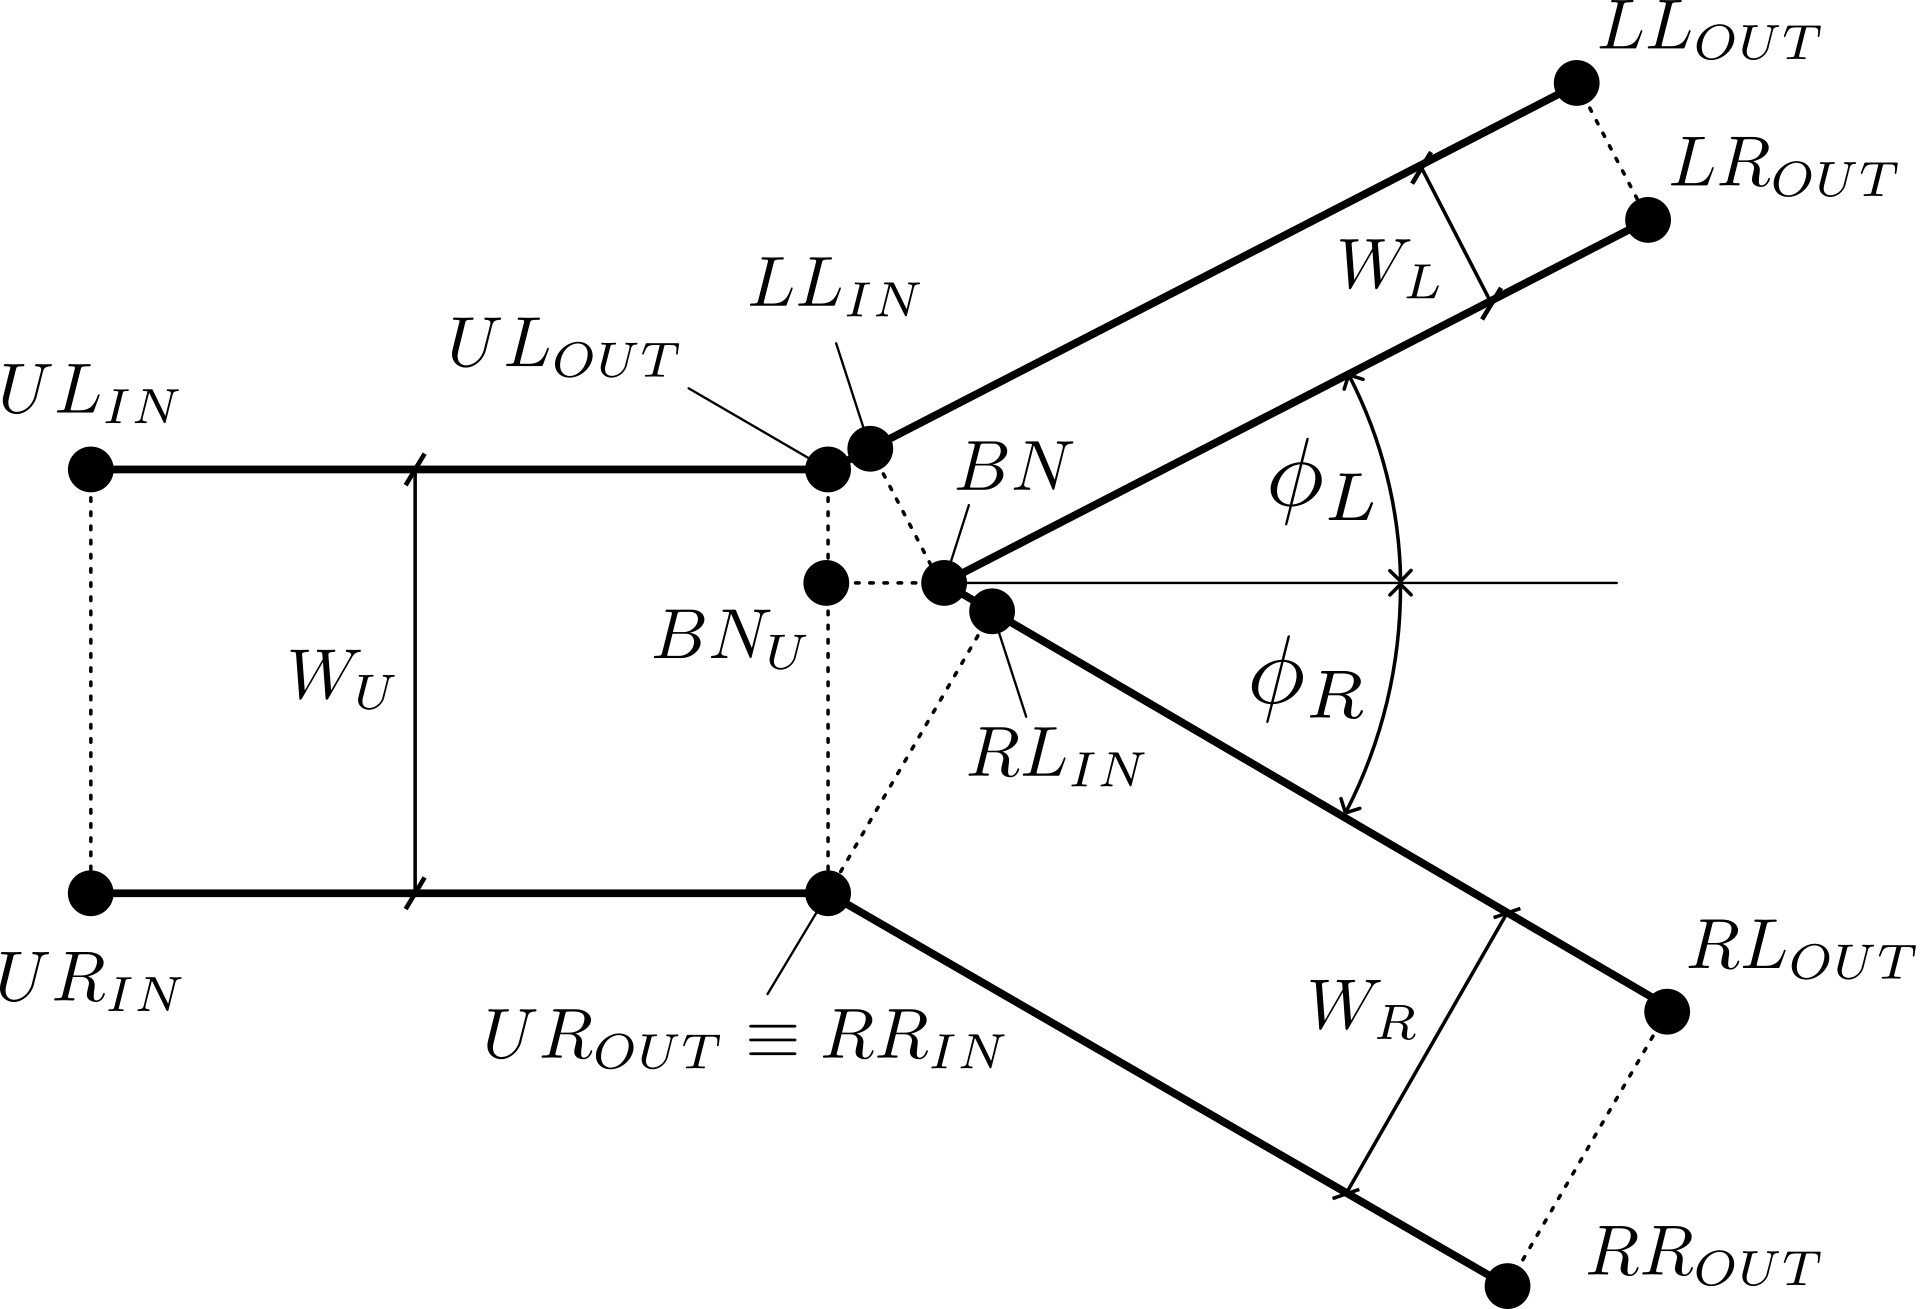

Initialize points' coordinates in the `xy` plane. Note that the origin of the reference system `(x, y, z) = (0, 0, 0)` is placed at the midpoint of the inlet cross-section of the upstream channel, i.e. at the midpoint between `UL_in` and `UR_in`. We also initialize the elevations of the points belonging to the upstream channel.

In [ ]:
# ----------------------------- Upstream channel ----------------------------- #
UL_in = Point(0, 0.5 * args.W_U, 0)  # left bank, inlet cross-section
UR_in = Point(0, -0.5 * args.W_U, 0)  # right bank, inlet cross-section
UL_out = Point(L_U, UL_in.y, UL_in.z - args.S_U * L_U)  # left bank, outlet cross-section
UR_out = Point(L_U, UR_in.y, UR_in.z - args.S_U * L_U)  # right bank, outlet cross-section

# ------------------------------- Right channel ------------------------------ #
RR_out = Point(
    UR_out.x + L_R * math.cos(phi_R), UR_out.y - L_R * math.sin(phi_R), None
)  # right bank, outlet cross-section
RL_out = Point(
    RR_out.x + W_R * math.sin(phi_R), RR_out.y + W_R * math.cos(phi_R), None
)  # left bank, outlet cross-section

# ------------------------------- Left channel ------------------------------- #
LL_out = Point(
    UL_out.x + L_L * math.cos(phi_L), UL_out.y + L_L * math.sin(phi_L), None
)  # left bank, outlet cross-section
LR_out = Point(
    LL_out.x + W_L * math.sin(phi_L), LL_out.y - W_L * math.cos(phi_L), None
    ) # right bank, outlet cross-section

Retrieve the `(x, y)` coordinates of the bifurcation point (`BN`) as the intersection between the two lines identified by the inner banks of channels L and R:

In [ ]:
LR_line = Line_xy(
    LR_out, Point(LR_out.x - math.cos(phi_L), LR_out.y - math.sin(phi_L), None)
)
RL_line = Line_xy(
    RL_out, Point(RL_out.x - math.cos(phi_R), RL_out.y + math.sin(phi_R), None)
)
BN = LR_line.intercept(RL_line)

Create the point `BN_U`, defined as the `xy` projection of the bifurcation node `BN` onto the outlet cross-section of the upstream channel

In [ ]:
BN_U = Point(UL_out.x, BN.y, UL_out.z)

Compute the distances between `BN_U` and the outlet cross-sections of the downstream branches, then compute the elevation of the latter by multiplying each distance with the corresponding bedslope 

In [ ]:
LL_out.z = LR_out.z = BN_U.z - args.S_L * BN_U.dist_from_line_xy(Line_xy(LL_out, LR_out))
RL_out.z = RR_out.z = BN_U.z - args.S_R * BN_U.dist_from_line_xy(Line_xy(RL_out, RR_out))

Shift the origin of the y axis to be consistent with ANUGA's `create_domain_from_regions` function, whose y axis has its origin at the point having the lowest value of y.

In [ ]:
y_min = RR_out.y
for i, p in enumerate([UL_in, UR_in, UL_out, UR_out, LL_out, LR_out, RL_out, RR_out, BN, BN_U]):
    p.y -= y_min

Define planes for downstream branches

In [ ]:
plane_L = Plane(BN_U, LL_out, LR_out)
plane_R = Plane(BN_U, RR_out, RL_out)

### Identify the inlet cross-section of both branches

Low-angle, low-width channels are more likely to have their inlet cross-section identified by the point next to `BN`, while the inlet cross-section of high-angle, high-width channels is identified by its outer boundary, i.e. either `UL_out` or `UR_out`.

Let's assume that the inlet step is applied to the left branch. To identify its inlet cross-section, we consider the two vectors `UL_out`-`LL_out` and `UL_out`-`BN` in the `xy` plane. If the angle between these two vectors is lower than 90°, the bifurcation node `BN` corresponds (on the`xy` plane) to the right end of the inlet cross-section. Otherwise, `UL_out` identifies the left end of the inlet cross-section.

In [ ]:
# -------------------------------- Left branch ------------------------------- #
u = diff_vector(BN, UL_out)
v = diff_vector(LL_out, UL_out)
if u.dot_product_xy(v) < 0:
    LL_in = Point(UL_out.x, UL_out.y, UL_out.z)
    LR_in = Point(
        LL_in.x + W_L * math.sin(phi_L), LL_in.y - W_L * math.cos(phi_L), LL_in.z
    )
else:
    LR_in = Point(BN.x, BN.y, plane_L.compute_z(BN.x, BN.y))
    LL_in = Point(
        LR_in.x - W_L * math.sin(phi_L), LR_in.y + W_L * math.cos(phi_L), LR_in.z
    )

# ------------------------------- Right branch ------------------------------- #
u = diff_vector(BN, UR_out)
v = diff_vector(RR_out, UR_out)
if u.dot_product_xy(v) < 0:
    RR_in = Point(UR_out.x, UR_out.y, UR_out.z)
    RL_in = Point(
        RR_in.x + W_R * math.sin(phi_R), RR_in.y + W_R * math.cos(phi_R), RR_in.z
    )
else:
    RL_in = Point(BN.x, BN.y, plane_R.compute_z(BN.x, BN.y))
    RR_in = Point(
        RL_in.x - W_R * math.sin(phi_R), RL_in.y - W_R * math.cos(phi_R), RL_in.z
    )

### Inlet step application

Increase the elevation of the points belonging to the superelevated branch, and create a new `Plane` object for the topography of the latter.

In [ ]:
if bathy_step_dim > 0:
    RL_in.z += abs(bathy_step_dim)
    RR_in.z += abs(bathy_step_dim)
    RR_out.z += abs(bathy_step_dim)
    RL_out.z += abs(bathy_step_dim)
    plane_R = Plane(RR_in, RR_out, RL_out)
else:
    LR_in.z += abs(bathy_step_dim)
    LL_in.z += abs(bathy_step_dim)
    LL_out.z += abs(bathy_step_dim)
    LR_out.z += abs(bathy_step_dim)
    plane_L = Plane(LL_in, LL_out, LR_out)

Define two new `Plane` objects for the ramps that connect the outlet cross-section of the upstream channel with the inlet cross-section of each branch. For the non-superelevated branch, the ramp coincides with the previously defined `Plane`.

In [ ]:
ramp_L = Plane(BN_U, LL_in, LR_in)
ramp_R = Plane(BN_U, RL_in, RR_in)

## Initialize the ANUGA domain

### Use `anuga.create_domain_from_regions` to initialize the anuga domain

Figure files for each frame will be stored in _plot


c:\Users\g-bar\miniconda3\envs\dorado-anuga\lib\site-packages\anuga\structures\riverwall.py:124: RuntimeWarning: invalid value encountered in cast
  self.hydraulic_properties_rowIndex=numpy.array([default_int]).astype(int)


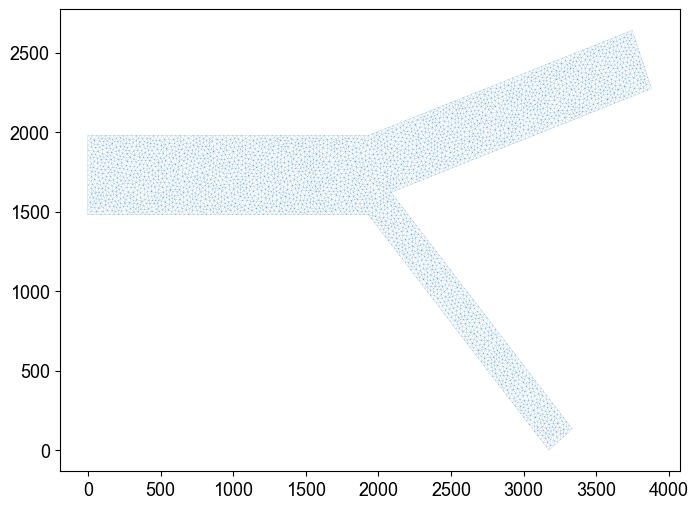

In [ ]:
bounding_polygon = [
    UR_in.xy(),
    UR_out.xy(),
    RR_out.xy(),
    RL_out.xy(),
    BN.xy(),
    LR_out.xy(),
    LL_out.xy(),
    UL_out.xy(),
    UL_in.xy(),
]


boundary_tags = {
    "inflow": [8],
    "outflow_right": [2],
    "outflow_left": [5],
    "banks": [0, 1, 3, 4, 6, 7],
}

mesh_filename = f"{sim_par_dir_name}_{sim_name}.msh"
domain = anuga.create_domain_from_regions(
    bounding_polygon, boundary_tags, maximum_triangle_area=args.max_triangle_area, mesh_filename=mesh_filename
)

os.remove(mesh_filename)
domain.set_datadir(sim_dir_path)
domain.set_name(swwfilename)
domain.set_store_vertices_smoothly(False)


dplotter1 = anuga.Domain_plotter(domain)
plt.triplot(dplotter1.triang, linewidth=0.1)

In [ ]:
domain.print_statistics()

------------------------------------------------
Mesh statistics:
  Number of triangles = 6767
  Extent [m]:
    x in [0.00000e+00, 3.88033e+03]
    y in [0.00000e+00, 2.64047e+03]
  Areas [m^2]:
    A in [1.71150e+02, 4.99975e+02]
    number of distinct areas: 6767
    Histogram:
      [1.71150e+02, 2.04033e+02[: 127
      [2.04033e+02, 2.36915e+02[: 745
      [2.36915e+02, 2.69798e+02[: 1152
      [2.69798e+02, 3.02680e+02[: 1139
      [3.02680e+02, 3.35563e+02[: 996
      [3.35563e+02, 3.68445e+02[: 896
      [3.68445e+02, 4.01328e+02[: 646
      [4.01328e+02, 4.34210e+02[: 494
      [4.34210e+02, 4.67092e+02[: 347
      [4.67092e+02, 4.99975e+02]: 225
    Percentiles (10 percent):
      676 triangles in [1.71150e+02, 2.31423e+02]
      676 triangles in [2.31423e+02, 2.51505e+02]
      676 triangles in [2.51505e+02, 2.69948e+02]
      676 triangles in [2.69948e+02, 2.87898e+02]
      676 triangles in [2.87898e+02, 3.08847e+02]
      676 triangles in [3.08847e+02, 3.31676e+02]
      

### Set IC for topography, water depth and roughness of the ANUGA domain

Function `topography` in the (x, y, z) space

In [ ]:
def topography(x, y, S_U, BN_U, ramp_L, ramp_R, plane_L, plane_R):
    """Computes the elevation of all mesh points, whose (x, y) coordinates
    are given in the input x and y arrays.
    """

    N = len(x)  # retrieve number of mesh elements
    z = np.zeros_like(x)

    for i in range(N):
        pt_i = Point(x[i], y[i], None)
        if pt_i.x < BN_U.x: # upstream channel
            z[i] = -S_U * pt_i.x
        elif pt_i.y > BN_U.y: # left channel
            # Check if the point is upstream or downstream the inlet cross-section
            if diff_vector(pt_i, LL_in).dot_product_xy(diff_vector(LL_out, LL_in)) > 0:
                z[i] = plane_L.compute_z(*pt_i.xy())
            else:
                z[i] = ramp_L.compute_z(*pt_i.xy())
        else: # right channel
            # Check if the point is upstream or downstream the inlet cross-section
            if diff_vector(pt_i, RR_in).dot_product_xy(diff_vector(RR_out, RR_in)) > 0:
                z[i] = plane_R.compute_z(*pt_i.xy())
            else:
                z[i] = ramp_R.compute_z(*pt_i.xy())
    return z

Set initial conditions for elevation, friction and water surface

In [ ]:
domain.set_quantity(
    "elevation", lambda x, y: topography(x, y, args.S_U, BN_U, ramp_L, ramp_R, plane_L, plane_R), location="centroids"
)  # Use function for elevation
#domain.set_quantity("elevation", lambda x, y: -x*S_U, location="centroids")

domain.set_quantity("friction", args.Manning_n, location="centroids")  # Constant friction

domain.set_quantity(
    "stage", expression="elevation", location="centroids"
)  # Dry Bed: set keyword argument expression='elevation'

### Plot domain

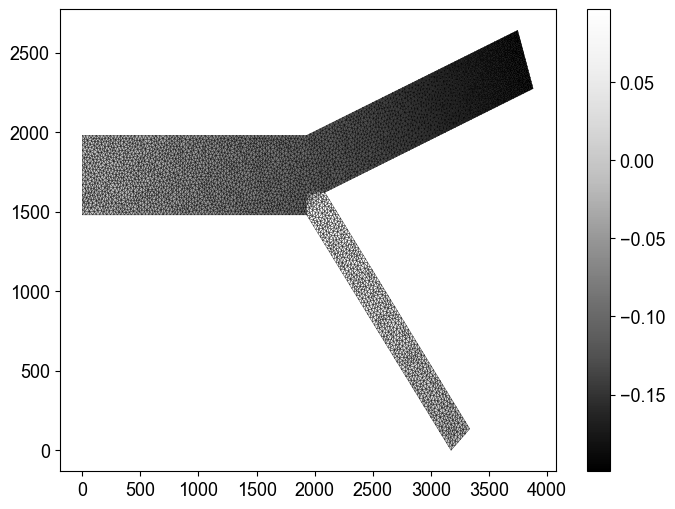

In [ ]:
plt.tripcolor(
    dplotter1.triang, facecolors=dplotter1.elev, edgecolors="k", cmap="Greys_r"
)
#plt.xlim([13000, 22000])
#plt.ylim([0, 9000])
#plt.xlim([21000, 22000])
#plt.ylim([8000, 9000])
plt.colorbar()

## Set boundary conditions

#### Class for new transmissive BC

In [ ]:
class Transmissive_stage_zero_momentum_w_subtraction_boundary(Boundary):
    """
    class written by Nelson Tull and modified from anuga's Transmissive_stage_zero_momentum_boundary

    BC where stage is *slightly less* than neighbour volume, momentum to zero.

    Underlying domain must be specified when boundary is instantiated
    """

    def __init__(self, domain=None, stage_diff=0):
        """ Instantiate a Transmissive (zero momentum) boundary.

        :stage_diff: value to subtract from boundary values of stage,
                           positive value indicates a subtraction
        """

        Boundary.__init__(self)

        if domain is None:
            msg = ('Domain must be specified for '
                   'Transmissive_stage_zero_momentum_w_subtraction_boundary')
            raise(Exception, msg)

        self.domain = domain
        self.stage_diff = stage_diff

    def __repr__(self):
        """ Return a representation of this instance. """
        return 'Transmissive_stage_zero_momentum_w_subtraction_boundary(%s)' % self.domain


    def evaluate(self, vol_id, edge_id):
        """Calculate transmissive (zero momentum) results, with slightly lower stage. """

        q = self.domain.get_conserved_quantities(vol_id, edge=edge_id)

        q[0] = q[0] - self.stage_diff
        q[1] = q[2] = 0.0

        return q


#### Impose the BC

In [ ]:
inflow_stage = UL_in.z+D_U
inflow_momentum = Q_U/args.W_U

# Bi = anuga.Dirichlet_boundary([inflow_stage, inflow_momentum, 0])  # Inflow
Bi = Dirichlet_discharge_boundary(domain, inflow_stage, inflow_momentum)
Bo = anuga.Transmissive_boundary(domain)  # Outflow
Br = anuga.Reflective_boundary(domain)  # Solid reflective wall

BoL = Transmissive_stage_zero_momentum_w_subtraction_boundary(domain, stage_diff=args.stage_diff)
BoR = Transmissive_stage_zero_momentum_w_subtraction_boundary(domain, stage_diff=args.stage_diff)
# BoL = anuga.Transmissive_boundary(domain)
# BoR = anuga.Transmissive_boundary(domain)
# BoL = anuga.Dirichlet_boundary([LL_out.z-5, 0, 0])
# BoR = anuga.Dirichlet_boundary([RL_out.z-5, 0, 0])
_ = anuga.Transmissive_stage_zero_momentum_boundary(domain)

domain.set_boundary(
    {"inflow": Bi, "outflow_left": BoL, "outflow_right": BoR, "banks": Br}
)

## Transects, seeding point and boundary polygon retrieval and export 

### Node transects

We define 3 sets of 3 transects each (one per branch) in the proximity of the bifurcation node. The name of each set refers to how far from the node the set is:
- `node0` is the set closest to the node, with two transects at the inlet cross-sections of the downstream channels and one at the outlet cross-section of the upstream channel
- `node1` and `node2` are located `W_U` further from the node with respect to the previous set.

Sometimes ANUGA won't find mesh elements if it's provided with coordinates that are at the edge of the domain; hence, a negative buffer may help making sure this doesn't happen.

Set `node0`

In [ ]:
t0_dict_list = []
buffer = 2*args.dx_dorado

tUL_0 = Point(UL_out.x, UL_out.y + buffer / 2, 0)
tUR_0 = Point(UR_out.x, UR_out.y - buffer / 2, 0)

tLL_0 = Point(0, 0, None)
tLR_0 = Point(0, 0, None)
tLL_0.x = LL_in.x - buffer / 2 * math.sin(phi_L)
tLL_0.y = LL_in.y + buffer / 2 * math.cos(phi_L)
tLR_0.x = tLL_0.x + (W_L + buffer) * math.sin(phi_L)
tLR_0.y = tLL_0.y - (W_L + buffer) * math.cos(phi_L)

tRL_0 = Point(0, 0, None)
tRR_0 = Point(0, 0, None)
tRR_0.x = RR_in.x - buffer / 2 * math.sin(phi_R)
tRR_0.y = RR_in.y - buffer / 2 * math.cos(phi_R)
tRL_0.x = tRR_0.x + (W_R + buffer) * math.sin(phi_R)
tRL_0.y = tRR_0.y + (W_R + buffer) * math.cos(phi_R)

t0_dict_list.append({"Bif_name": "SDB", "label": "0", "X": tUL_0.x, "Y": tUL_0.y})
t0_dict_list.append({"Bif_name": "SDB", "label": "0", "X": tUR_0.x, "Y": tUR_0.y})
t0_dict_list.append({"Bif_name": "SDB", "label": "L", "X": tLL_0.x, "Y": tLL_0.y})
t0_dict_list.append({"Bif_name": "SDB", "label": "L", "X": tLR_0.x, "Y": tLR_0.y})
t0_dict_list.append({"Bif_name": "SDB", "label": "R", "X": tRL_0.x, "Y": tRL_0.y})
t0_dict_list.append({"Bif_name": "SDB", "label": "R", "X": tRR_0.x, "Y": tRR_0.y})

t0_df = pd.DataFrame(t0_dict_list)
t0_df.to_csv(os.path.join(sim_coords_dir_path, "transects_node0_coords.csv"), index=False)

Set `node1`

In [ ]:
t1_dict_list = []

tUL_1 = Point(tUL_0.x - args.W_U, tUL_0.y, None)
tUR_1 = Point(tUR_0.x - args.W_U, tUR_0.y, None)
tLL_1 = Point(tLL_0.x + args.W_U * math.cos(phi_L), tLL_0.y + args.W_U * math.sin(phi_L), None)
tLR_1 = Point(tLR_0.x + args.W_U * math.cos(phi_L), tLR_0.y + args.W_U * math.sin(phi_L), None)
tRL_1 = Point(tRL_0.x + args.W_U * math.cos(phi_R), tRL_0.y - args.W_U * math.sin(phi_R), None)
tRR_1 = Point(tRR_0.x + args.W_U * math.cos(phi_R), tRR_0.y - args.W_U * math.sin(phi_R), None)

t1_dict_list.append({"Bif_name": "SDB", "label": "0", "X": tUL_1.x, "Y": tUL_1.y})
t1_dict_list.append({"Bif_name": "SDB", "label": "0", "X": tUR_1.x, "Y": tUR_1.y})
t1_dict_list.append({"Bif_name": "SDB", "label": "L", "X": tLL_1.x, "Y": tLL_1.y})
t1_dict_list.append({"Bif_name": "SDB", "label": "L", "X": tLR_1.x, "Y": tLR_1.y})
t1_dict_list.append({"Bif_name": "SDB", "label": "R", "X": tRL_1.x, "Y": tRL_1.y})
t1_dict_list.append({"Bif_name": "SDB", "label": "R", "X": tRR_1.x, "Y": tRR_1.y})

t1_df = pd.DataFrame(t1_dict_list)
t1_df.to_csv(os.path.join(sim_coords_dir_path, "transects_node1_coords.csv"), index=False)

Set `node2`

In [ ]:
t2_dict_list = []

tUL_2 = Point(tUL_1.x - args.W_U, tUL_1.y, None)
tUR_2 = Point(tUR_1.x - args.W_U, tUR_1.y, None)
tLL_2 = Point(tLL_1.x + args.W_U * math.cos(phi_L), tLL_1.y + args.W_U * math.sin(phi_L), None)
tLR_2 = Point(tLR_1.x + args.W_U * math.cos(phi_L), tLR_1.y + args.W_U * math.sin(phi_L), None)
tRL_2 = Point(tRL_1.x + args.W_U * math.cos(phi_R), tRL_1.y - args.W_U * math.sin(phi_R), None)
tRR_2 = Point(tRR_1.x + args.W_U * math.cos(phi_R), tRR_1.y - args.W_U * math.sin(phi_R), None)

t2_dict_list.append({"Bif_name": "SDB", "label": "0", "X": tUL_2.x, "Y": tUL_2.y})
t2_dict_list.append({"Bif_name": "SDB", "label": "0", "X": tUR_2.x, "Y": tUR_2.y})
t2_dict_list.append({"Bif_name": "SDB", "label": "L", "X": tLL_2.x, "Y": tLL_2.y})
t2_dict_list.append({"Bif_name": "SDB", "label": "L", "X": tLR_2.x, "Y": tLR_2.y})
t2_dict_list.append({"Bif_name": "SDB", "label": "R", "X": tRL_2.x, "Y": tRL_2.y})
t2_dict_list.append({"Bif_name": "SDB", "label": "R", "X": tRR_2.x, "Y": tRR_2.y})

t2_df = pd.DataFrame(t2_dict_list)
t2_df.to_csv(os.path.join(sim_coords_dir_path, "transects_node2_coords.csv"), index=False)

### Longitudinal transects

Used to plot longitudinal profiles of stage and bed. They connect the centroid of each transect of the set `node0` (the closest to the node) with the centroid of the corresponding transect of the set `node2` (the furthest from the node).

In [ ]:
tUU = Point(tUL_2.x, 0.5*(tUL_2.y+tUR_2.y), None)
tUD = Point(tUL_0.x, 0.5*(tUL_0.y+tUR_0.y), None)
tLU = Point(0.5*(tLL_0.x+tLR_0.x), 0.5*(tLL_0.y+tLR_0.y), None)
tLD = Point(0.5*(tLL_2.x+tLR_2.x), 0.5*(tLL_2.y+tLR_2.y), None)
tRU = Point(0.5*(tRL_0.x+tRR_0.x), 0.5*(tRL_0.y+tRR_0.y), None)
tRD = Point(0.5*(tRL_2.x+tRR_2.x), 0.5*(tRL_2.y+tRR_2.y), None)

tlong_dict_list = []
tlong_dict_list.append({"Bif_name": "SDB", "label": "0", "X": tUU.x, "Y": tUU.y})
tlong_dict_list.append({"Bif_name": "SDB", "label": "0", "X": tUD.x, "Y": tUD.y})
tlong_dict_list.append({"Bif_name": "SDB", "label": "L", "X": tLU.x, "Y": tLU.y})
tlong_dict_list.append({"Bif_name": "SDB", "label": "L", "X": tLD.x, "Y": tLD.y})
tlong_dict_list.append({"Bif_name": "SDB", "label": "R", "X": tRU.x, "Y": tRU.y})
tlong_dict_list.append({"Bif_name": "SDB", "label": "R", "X": tRD.x, "Y": tRD.y})

tlong_df = pd.DataFrame(tlong_dict_list)
tlong_df.to_csv(os.path.join(sim_coords_dir_path, "transects_long_coords.csv"), index=False)

### Exports bounding polygon and seeding point for dorado simulation

Save bounding polygon to a csv file

In [ ]:
np.savetxt(os.path.join(sim_coords_dir_path,"bounds.csv"), bounding_polygon, delimiter=",", fmt="%.3f")

Save coordinates of bifurcation point (useful to center plots)

In [ ]:
np.savetxt(os.path.join(sim_coords_dir_path, "bif_point.csv"), BN.xy(), fmt="%.3f")

Compute coordinates of seeding point and save them to a csv file

In [ ]:
seed_pt = Point(args.W_U, 0.5*(UL_in.y+UR_in.y), None)
np.savetxt(os.path.join(sim_coords_dir_path, "seed_point.csv"), seed_pt.xy(), fmt="%.3f")

# Run the simulation

In [ ]:

for branch in domain.evolve(yieldstep=args.yieldstep, duration=args.duration):
    # dplotter.plot_depth_frame()
    # dplotter1.save_depth_frame(vmin=0, vmax=2*D_U)

    domain.print_timestepping_statistics()


# Read in the png files stored during the evolve loop
# dplotter1.make_depth_animation()


Time = 0.0000 (sec), steps=0 (1s)
Time = 1000.0000 (sec), delta t in [0.50111732, 0.82516594] (s), steps=1741 (13s)
Time = 2000.0000 (sec), delta t in [0.59066925, 0.59931523] (s), steps=1679 (17s)
Time = 3000.0000 (sec), delta t in [0.59931552, 0.60355028] (s), steps=1663 (27s)
Time = 4000.0000 (sec), delta t in [0.60355111, 0.61320295] (s), steps=1646 (19s)


### Retrieve the time series of flow discharge at each transect

Check if the simulation has reached a steady state by looking at the time evolution of the discharge entering each branch.

Keep in mind that if $dQ/dx=0$, then $dD/dt=0$ for mass continuity

Define time indexes to look at

In [ ]:
time_idxs = np.arange(-10, 0, step=1, dtype=int)

Retrieve coordinates of the transects in ANUGA's reference system

In [ ]:
t_coords = {}

# Node transects
for t_set in ["node0", "node1", "node2"]:
    t_coords[t_set] = atx.extract_transects_UTM_coord(os.path.join(sim_coords_dir_path,f"transects_{t_set}_coords.csv"))["SDB"]

# Add inflow transect
t_coords["inflow"] = {'0': [(UL_in.x+args.W_U, UL_in.y+buffer/2), (UR_in.x+args.W_U, UR_in.y-buffer/2)]}

Compute flow time series for each transect using `manualFlowThruTransect`

In [ ]:
t_Q_time = None

if args.compute_t_Q_time:
    for t_set in t_coords:
        print(f"Transect set = {t_set}")
        t_Q_time[t_set] = {}
        for branch in t_coords[t_set]:
            t_Q_time[t_set][branch] = []
            for time_idx in time_idxs:
                t_Q_time[t_set][branch].append(
                    atx.manualFlowThruTransect(
                        t_coords[t_set][branch], swwfilepath, sww_ind=time_idx
                    )
                )

Save the last value of the time series of each transect to a json file. We consider the absolute value

In [ ]:
if t_Q_time is not None:
    t_Q_time_out = {
        t_set: {branch: abs(t_Q_time[t_set][branch][-1]) for branch in t_Q_time[t_set]}
        for t_set in t_Q_time
    }
    with open(os.path.join(sim_dir_path, "outputs_ANUGA_mesh.json"), "w") as f:
        json.dump(t_Q_time_out, f, indent=4)

Plot time series

In [ ]:
if t_Q_time is not None:
    cmap = mpl.colormaps['viridis']
    branch_colors = cmap(np.linspace(0,1,len(t_Q_time)))
    set_linestyles = ['-', '-.', '--']

    plt.figure() # needed to not overlap figures in the script
    for branch, color in zip(t_Q_time["node0"], branch_colors):
        for t_set, ls in zip(t_Q_time, set_linestyles):
            Q = -np.array(t_Q_time[t_set][branch])
            plt.plot(time_idxs, Q, label=f"{t_set}_{branch}", color=color, ls=ls)

    plt.plot(time_idxs, -np.array(t_Q_time["inflow"]["0"]), color="black", label="inflow")

    plt.grid()
    plt.legend(title="Transect ID", ncols=1, bbox_to_anchor=(1, 0.8))
    plt.tight_layout(rect=(0, 0, 1, 1))
    plt.xlabel("Time index")
    plt.ylabel(r"Flow discharge [m$^3$/s]")
    #plt.ylim([1300, 1345])
    plt.savefig(os.path.join(sim_dir_path, "transects_flow_over_time.png"), bbox_inches='tight')

### Cleanup of temporary files

Clear .msh files and folder with png snapshots

In [ ]:
atx.clear_temp_folder("_plot")

# Import solution to dorado grid and make plots

Load the solution into a dorado grid and initialize a params object

In [ ]:
my_swwvals = atx.import_ANUGA_flow_field(
    swwfilepath,
    args.dx_dorado,
    bounds_path=os.path.join(sim_coords_dir_path, "bounds.csv"),
)

params = atx.init_dorado_params(args.dx_dorado, 1.0, my_swwvals)

Retrieve coordinates of bifurcation points (useful to center plots) in dorado's reference system

In [ ]:
BN_coords = np.loadtxt(os.path.join(sim_coords_dir_path, "bif_point.csv"))
BN_pt = pt.coord2ind(
    [(BN_coords[0], BN_coords[1])],
    (min(my_swwvals["x"]), min(my_swwvals["y"])),
    np.shape(my_swwvals["depth"]),
    args.dx_dorado,
)

Import transects coordinates, convert them in dorado grid reference system and plot the transects over a depth map

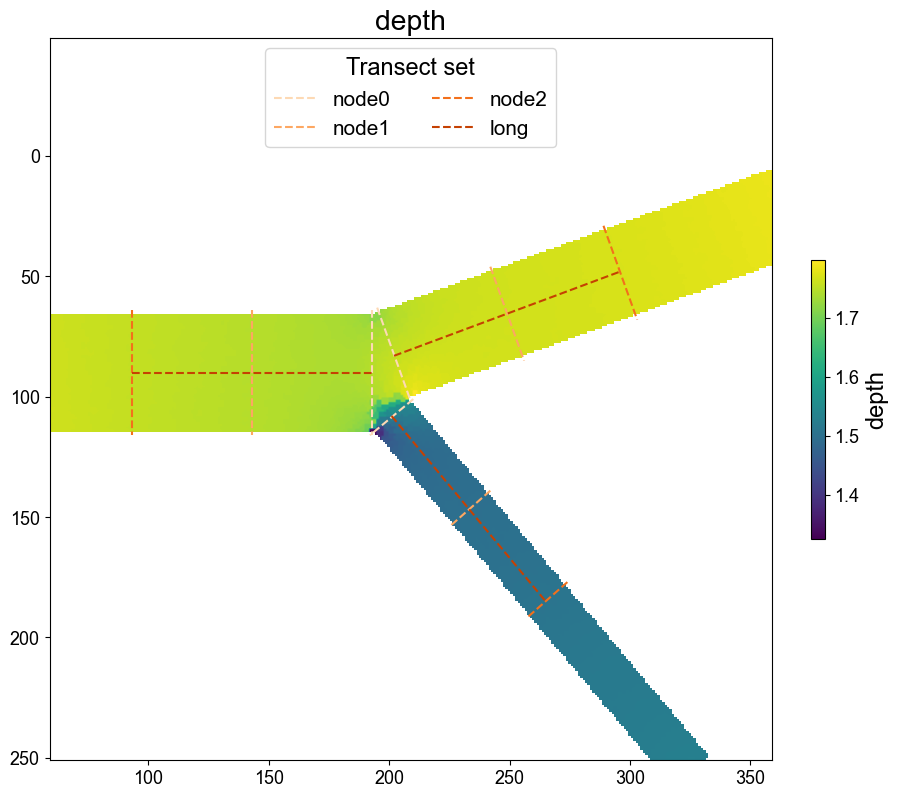

In [ ]:
t_sets = ["node0", "node1", "node2", "long"]

plot_buffer = 3*np.round(args.W_U/args.dx_dorado)
cmap = mpl.colormaps['Oranges']
t_colors = cmap(np.linspace(0.2,0.8,len(t_sets)))

t_all = {}

plt.figure(figsize=(10, 10))
plt.title("depth")
plt.imshow(my_swwvals["depth"], cmap="viridis")
plt.colorbar(fraction=0.018, label="depth")
plt.xlim([BN_pt[0][1]-plot_buffer, BN_pt[0][1]+plot_buffer])
plt.ylim([BN_pt[0][0]+plot_buffer, BN_pt[0][0]-plot_buffer])

for t_set in t_sets:
    t_all[t_set] = atx.extract_transects_index_coord(os.path.join(sim_coords_dir_path, f"transects_{t_set}_coords.csv"), my_swwvals, args.dx_dorado)

lines = []
labels = []
for color, t_set_name in zip(t_colors, t_all):
    for bif in t_all[t_set_name]:
        for branch in t_all[t_set_name][bif]:
            x_t = [t_all[t_set_name][bif][branch][0][0], t_all[t_set_name][bif][branch][1][0]]
            y_t = [t_all[t_set_name][bif][branch][0][1], t_all[t_set_name][bif][branch][1][1]]
            line, = plt.plot(y_t, x_t, '--', linewidth=1.5, color=color)
            label = t_set_name
        lines.append(line)
        labels.append(label)
plt.legend(title="Transect set", handles=lines, labels=labels, ncols=2, loc="upper center")
plt.savefig(os.path.join(sim_dir_path, "node_transects_map.png"))

#### Plot the domain maps and save them to simulation folder

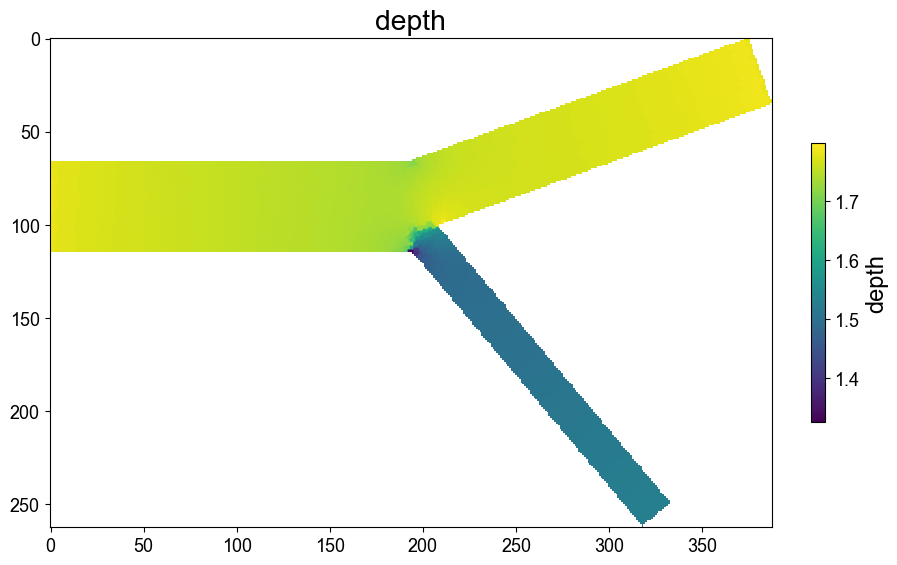

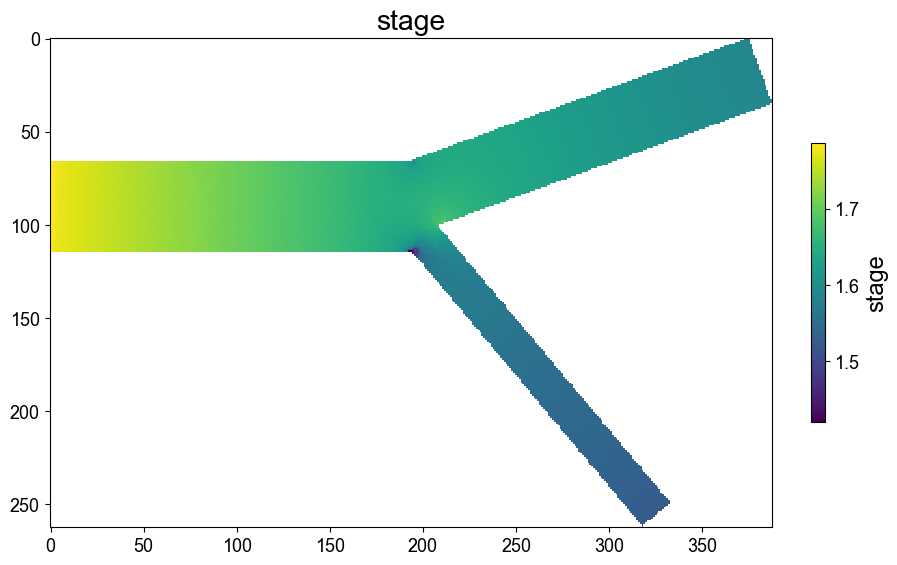

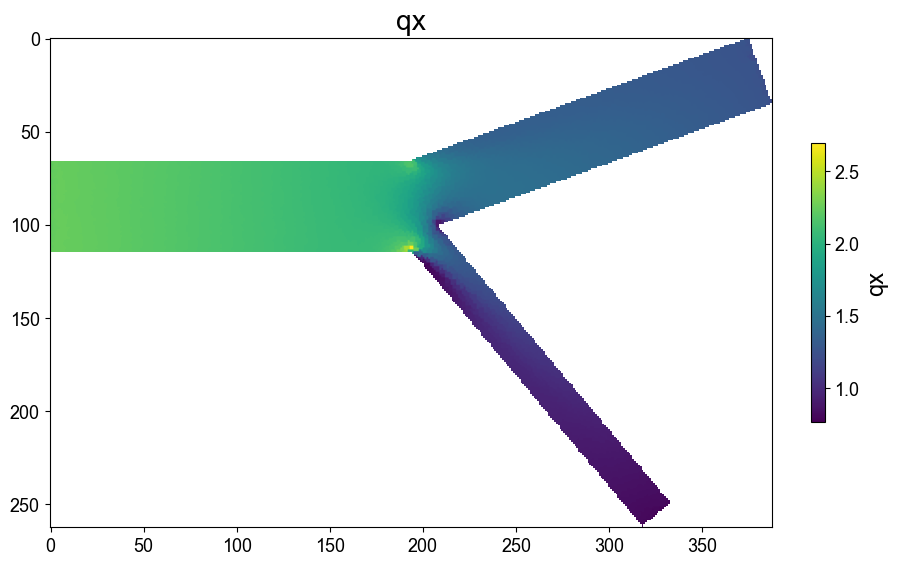

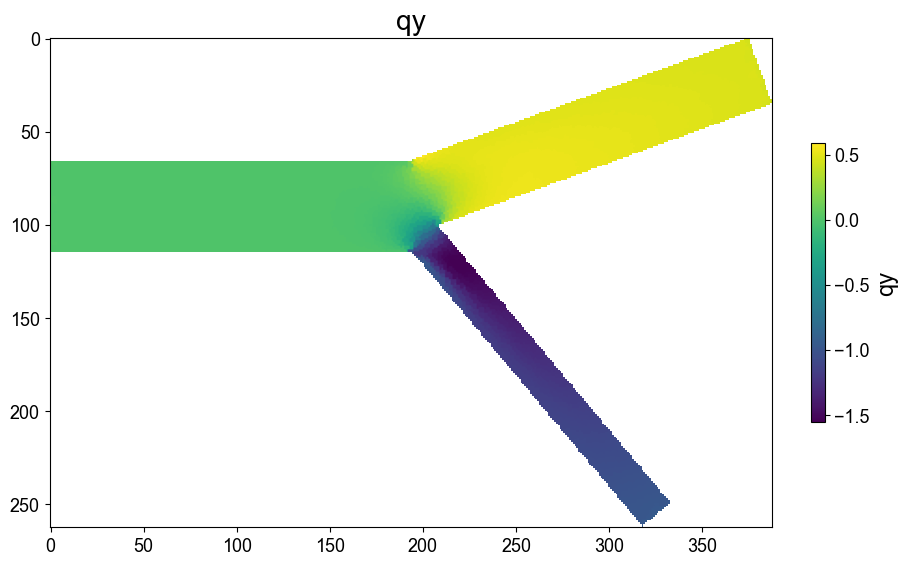

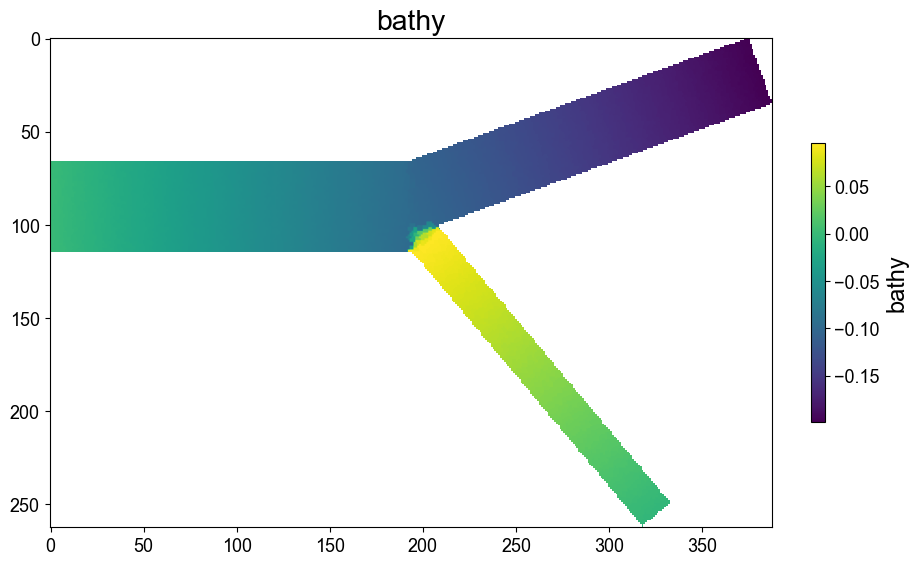

In [ ]:
atx.plot_ANUGA_sim_domain_maps(my_swwvals, maps_domain_path)

#### Plot for paper

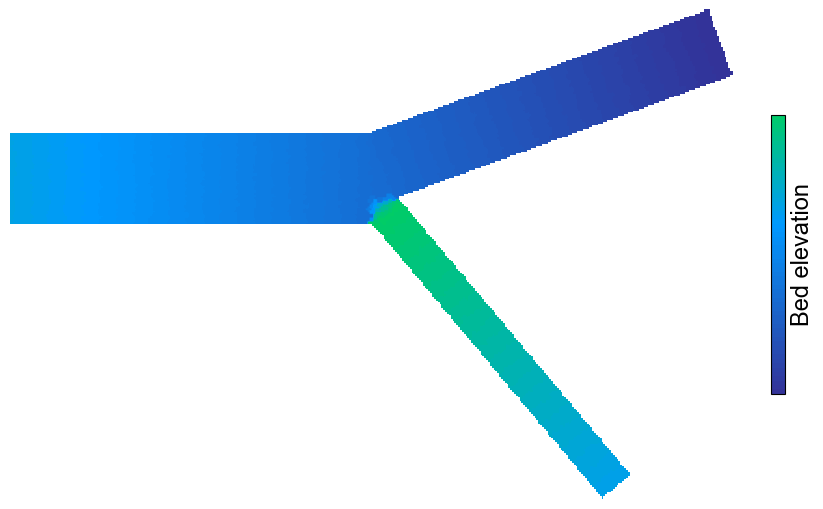

In [ ]:
out_path = fr"C:\Users\g-bar\Work\Research\Projects\core\SDB\figures\PAP3"

import matplotlib.colors as mcolors

var = "bathy"
plt.figure(figsize=(10, 10))

terrain_cmap = plt.get_cmap('terrain')

# Define the slice of the colormap you want
start = 0.0  # Start of the slice (0.0 to 1.0)
end = 0.25    # End of the slice (0.0 to 1.0)
terrain_slice = mcolors.LinearSegmentedColormap.from_list(
    'terrain_slice', terrain_cmap(np.linspace(start, end, 256))
)

# Plot the data with the sliced colormap
plt.imshow(my_swwvals[var], cmap=terrain_slice)
plt.colorbar(fraction=0.018, label="Bed elevation", ticks=[])
plt.axis('off')
plt.savefig(os.path.join(out_path, "SDB_sketch.pdf"), bbox_inches="tight")

#### Plot cross-sections for all transects sets

Node transects

Plotting cross-sections...
Plotting cross-sections...
Plotting cross-sections...


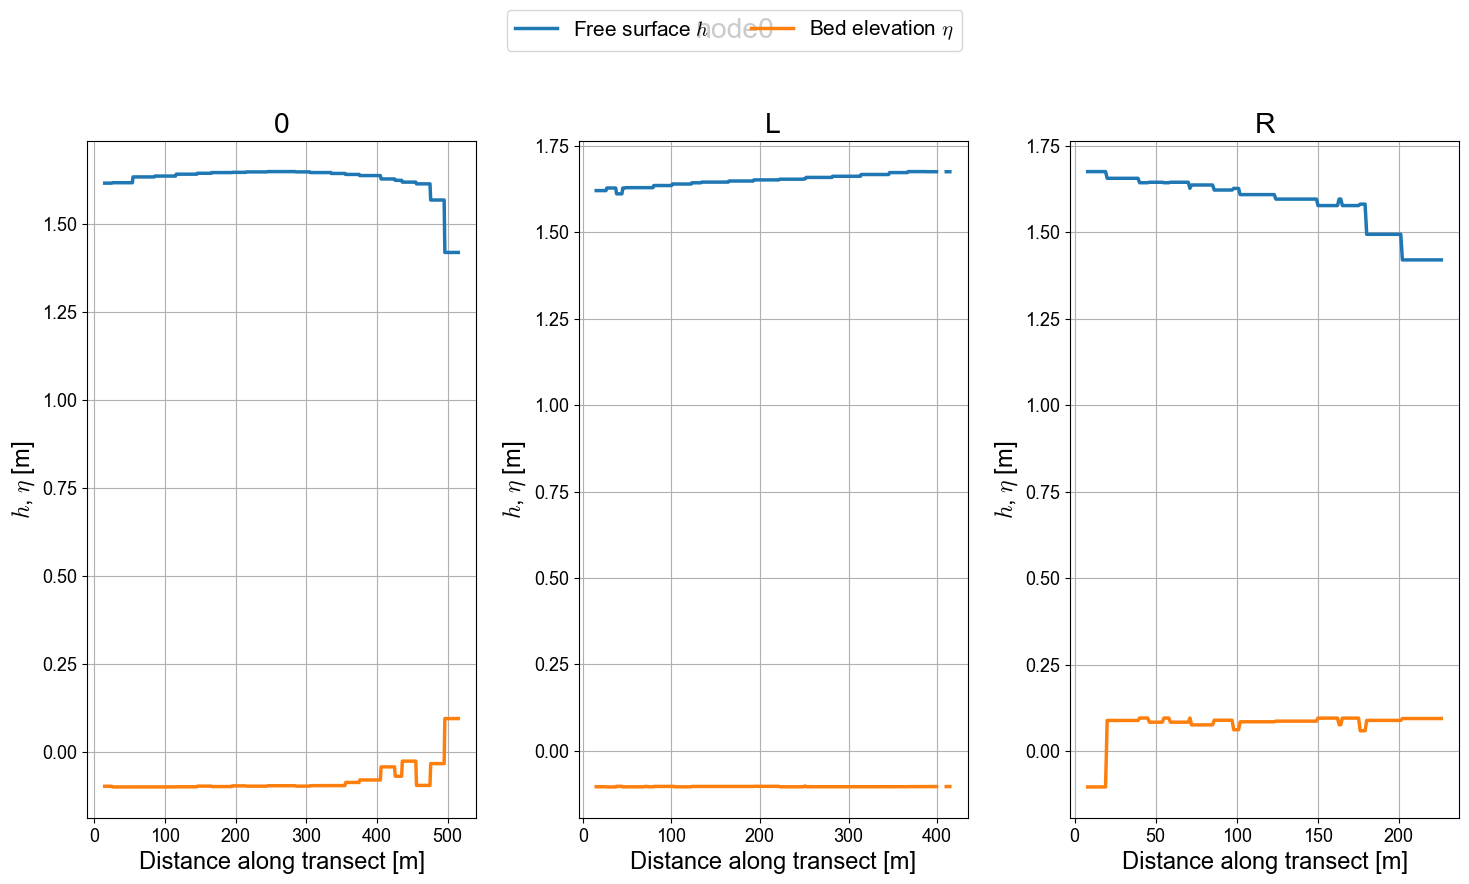

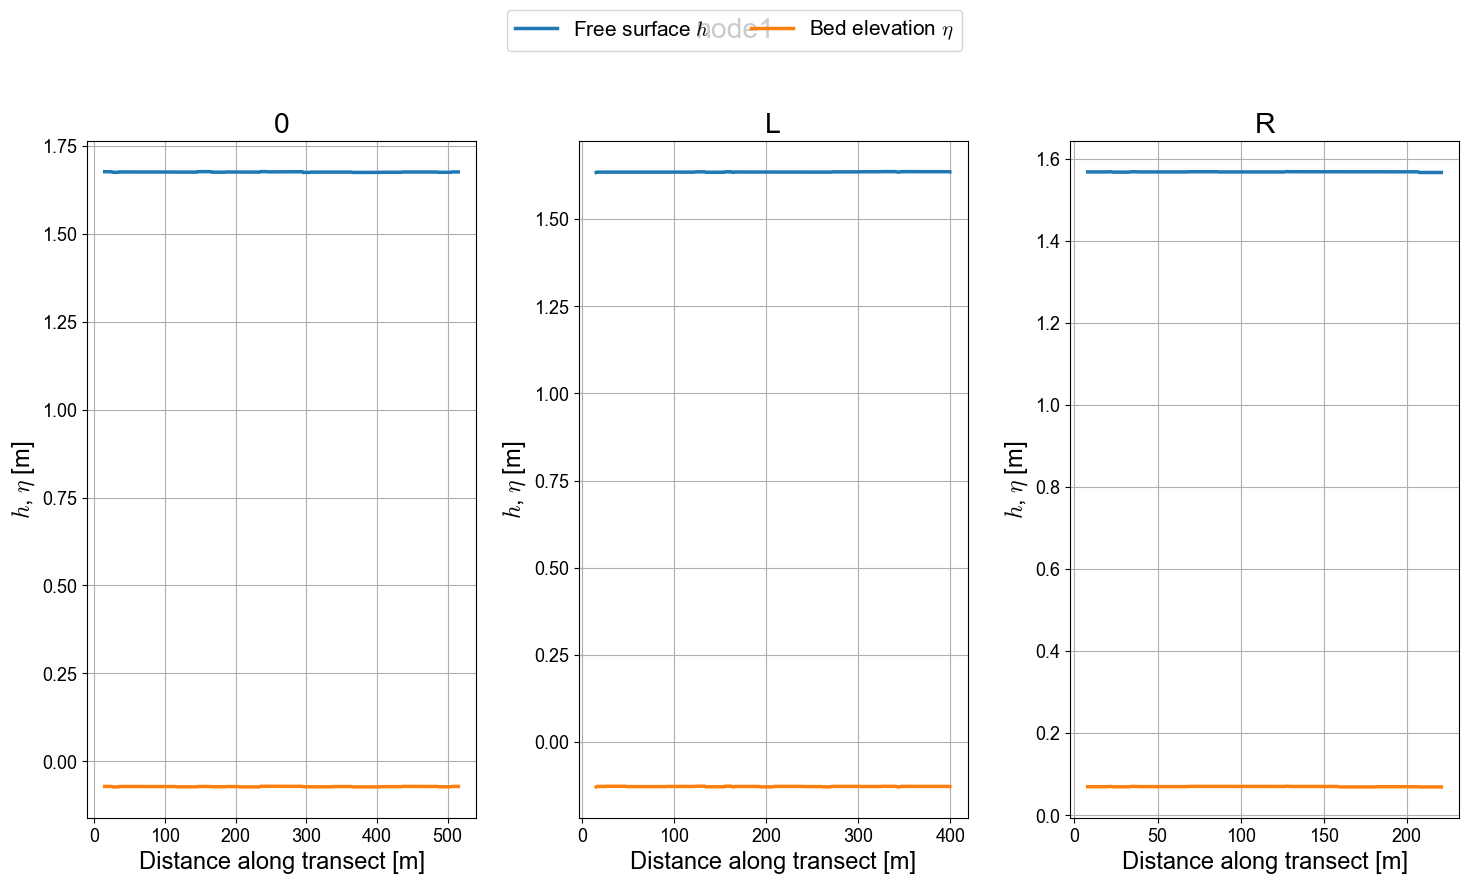

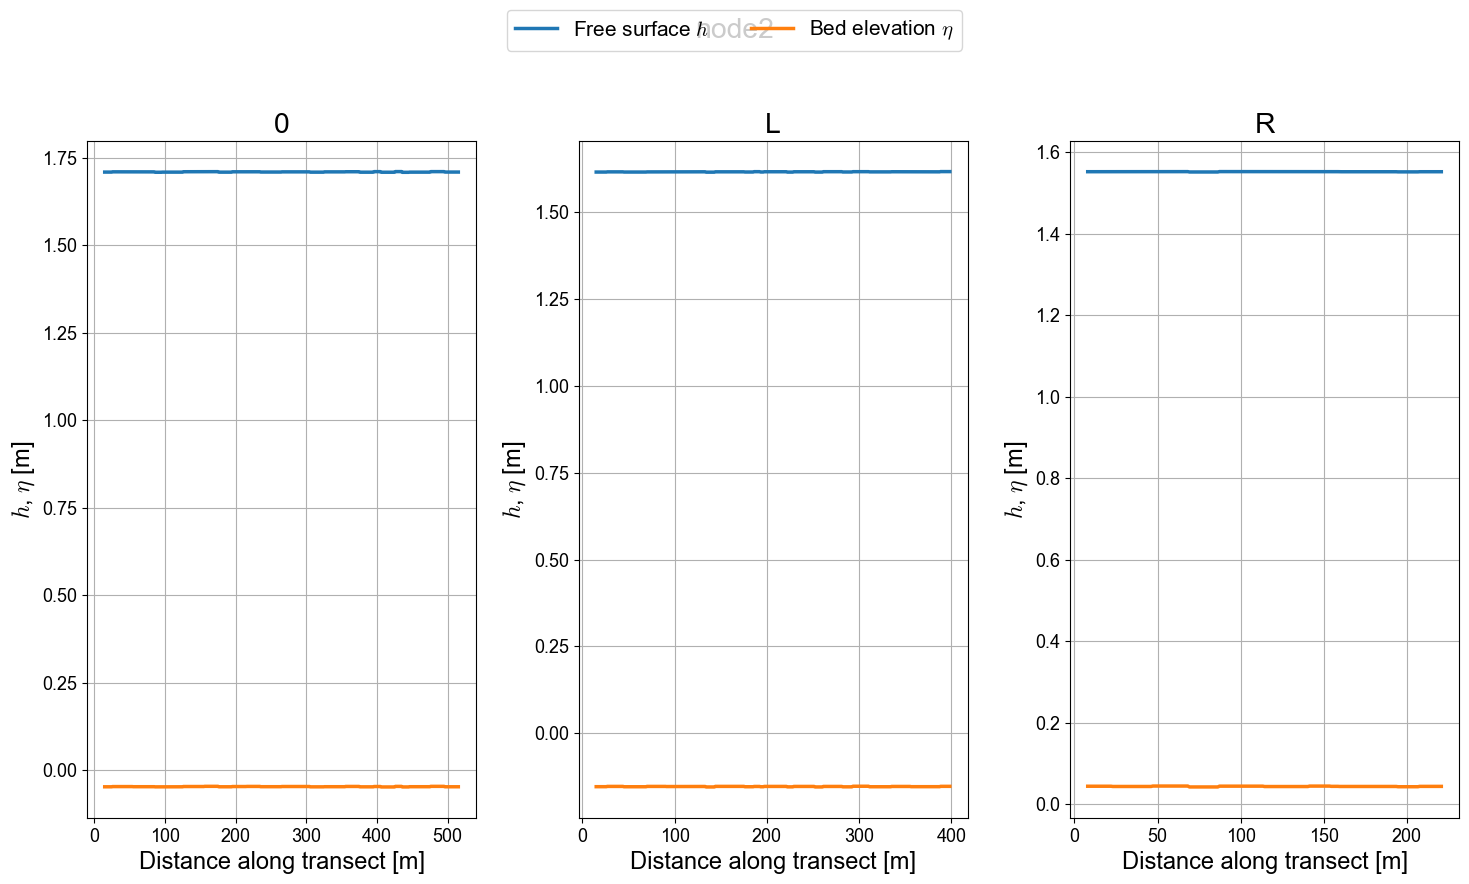

In [ ]:
for t_set in ["node0", "node1", "node2"]:
    atx.plot_cross_sections(t_all[t_set], params, xsections_plots_path, plot_lims=None, xs_name=f"_{t_set}", suptitle=t_set)

Longitudinal transects

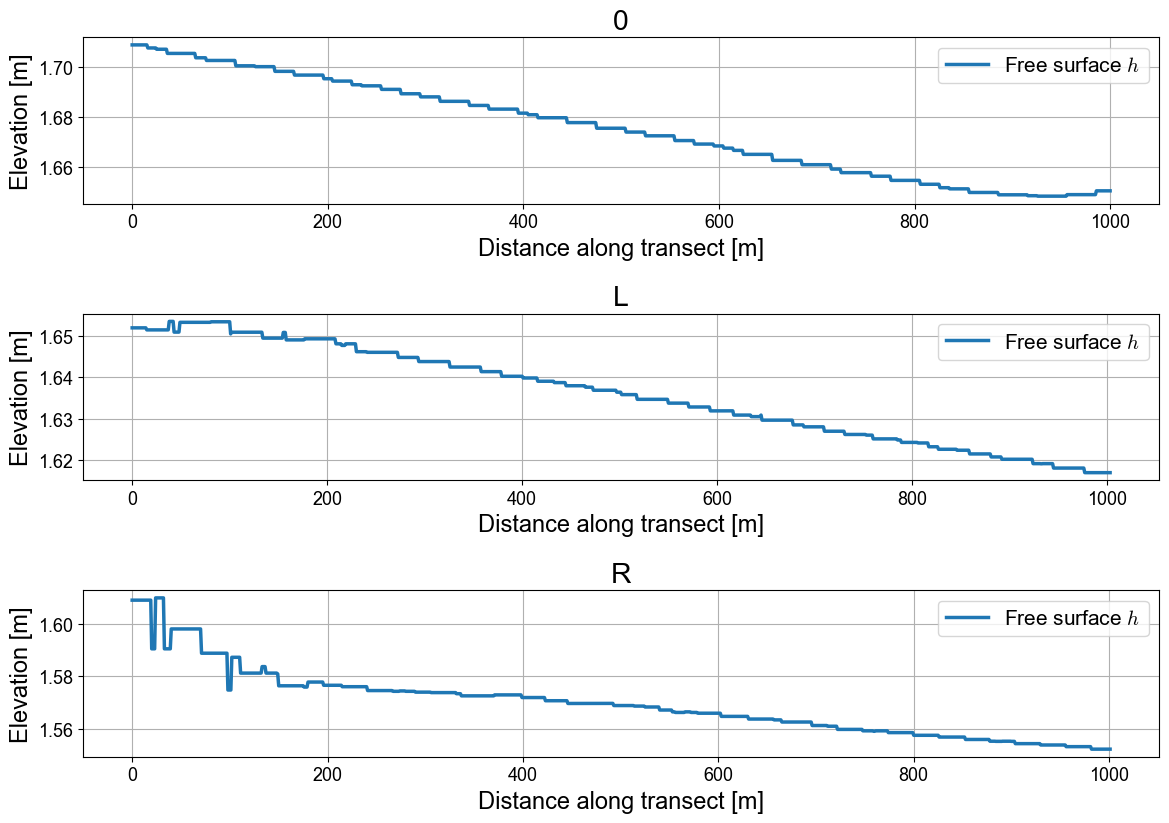

In [ ]:
atx.plot_long_profiles(
    t_all["long"]["SDB"], params, xsections_plots_path, xs_name=f"_long"
)  # , suptitle="Long profiles")

# Compute asymmetries, perform tests

Initialize dictionary for outputs

In [ ]:
out_d = {}

Compute average flow discharge, water depth and channel width for each transect

In [ ]:
out_d["QDW_transects"] = {}
for t_set in t_all:
    if t_set != "long":
        out_d["QDW_transects"][t_set] = {}
        for branch in t_all[t_set]["SDB"]:
            Q, D, W = atx.transect_get_Q_D_W(t_all[t_set]["SDB"][branch], params)
            out_d["QDW_transects"][t_set][branch] = {"Q": Q, "D": D, "W": W}

Compute flow discharge and depth asymmetries (both defined as difference over sum) for each set of transects

In [ ]:
out_d["asymmetries"] = {}
for t_set in out_d["QDW_transects"]:
    t_d = out_d["QDW_transects"][t_set]
    DeltaQ = (t_d['L']['Q']-t_d['R']['Q'])/(t_d['L']['Q']+t_d['R']['Q'])
    bathy_step_dim = (t_d['L']['D']-t_d['R']['D'])/(t_d['L']['D']+t_d['R']['D'])
    out_d["asymmetries"][t_set] = {"DeltaQ": DeltaQ, "DeltaD": bathy_step_dim}

Save output dictionary as a .json file in the simulation folder

In [ ]:
with open(os.path.join(sim_dir_path, "outputs_ANUGA_dorado_grid.json"), "w") as f:
    json.dump(out_d, f, indent=4)